#### Load necessary packages

In [1]:
import os
import sys
sys.path.insert(0,'../../../mocsy')

In [2]:
import numpy as np
import copy
import xarray as xr
import pandas as pd
from tqdm import tqdm
import pickle 
import random
import matplotlib.pyplot as plt
from scipy import stats

import mocsy
from mocsy import mvars
from mocsy import mrhoinsitu
from mocsy import mrho
from mocsy import mp2fco2

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#### Test transformation of pCO2 data to fCO2 data

In [65]:
mp2fco2?


def extend(number, template):
    """
    helper function allowing calc_fco2_from_pco2 to work on floats and arrays.
    """
    template_type = "array" if isinstance(template, np.ndarray) else "float"
    if template_type == "array":
        return number * np.ones(template.shape)
    elif template_type == "float":
        return number

def calc_fCO2_from_pCO2(pco2,tem):
    """
    input units
    pco2 inmuatm
    tem in °C
    """
    if len(pco2.shape) > 1:
        pco2_flat = pco2.flatten(order="C")
        tem_flat = tem.flatten(order="C")
        fco2 = mp2fco2(pco2=pco2_flat, temp=tem_flat,
                       patm=extend(1, pco2_flat), p=extend(5, pco2_flat))
        return np.reshape(fco2, newshape=pco2.shape, order='C')
    else:
        return mp2fco2(pco2=pco2, temp=tem, patm=extend(1, pco2), p=extend(5, pco2))

def calc_fCO2(alk, dic, tem, sal, sil, phos):
    """
    input units
    alk in mol / kg
    dic in mol / kg
    tem in °C
    sal in PSU
    sil in mol / kg
    phos in mol / kg
    """
    return mvars(alk=alk,
                     dic=dic,
                     temp=tem,
                     sal=sal,
                     sil=sil,
                     phos=phos,
                     patm=extend(1, alk),
                     depth=extend(5, alk),
                     lat=extend(np.nan, alk),
                     optcon='mol/kg',
                     optt='Tpot',
                     optp='db',
                     optk1k2='l',
                     optb='u74',
                     optkf='pf',
                     opts='Sprc')[2]

def calc_pCO2(alk, dic, tem, sal, sil, phos):
    """
    input units
    alk in mol / kg
    dic in mol / kg
    tem in °C
    sal in PSU
    sil in mol / kg
    phos in mol / kg
    """
    return mvars(alk=alk,
                     dic=dic,
                     temp=tem,
                     sal=sal,
                     sil=sil,
                     phos=phos,
                     patm=extend(1, alk),
                     depth=extend(5, alk),
                     lat=extend(np.nan, alk),
                     optcon='mol/kg',
                     optt='Tpot',
                     optp='db',
                     optk1k2='l',
                     optb='u74',
                     optkf='pf',
                     opts='Sprc')[1]

Call signature: mp2fco2(*args, **kwargs)
Type:           fortran
String form:    <fortran object>
Docstring:     
fco2 = p2fco2(pco2,temp,patm,p)

Wrapper for ``p2fco2``.

Parameters
----------
pco2 : input rank-1 array('d') with bounds (n)
temp : input rank-1 array('d') with bounds (n)
patm : input rank-1 array('d') with bounds (n)
p : input rank-1 array('d') with bounds (n)

Returns
-------
fco2 : rank-1 array('d') with bounds (n)

In [5]:
fco2 = calc_fCO2(alk=2300e-6, dic=2000e-6, tem=18, sal=35, sil=0, phos=0)
print("fCO2: {:.2f}".format(fco2[0]))
pco2 = calc_pCO2(alk=2300e-6, dic=2000e-6, tem=18, sal=35, sil=0, phos=0)
print("pCO2: {:.2f}".format(pco2[0]))
print("fCO2 calculated from pCO2: {:.2f}".format(
    calc_fCO2_from_pCO2(pco2, tem=18)[0]))

fCO2: 297.26
pCO2: 298.81
fCO2 calculated from pCO2: 297.26


# Training data

#### Read in the data

In [6]:
ds_socat = xr.open_dataset("../../data/SOCATv2023_tracks_gridded_monthly.nc").sel(tmnth=slice('1993-01-01', '2022-12-31'))
# load 
def concat_hist_ssp(hist_array, ssp_array):
    return np.concatenate([hist_array[-22*12:, :], ssp_array[:8*12, :]], axis=0)

def expand_co2(co2_array):
    return np.repeat(np.repeat(co2_array, 15, axis=1)[:, :, np.newaxis], 360, axis=2)

In [7]:
base = "/home/friedrich/Downloads/cmip6/"
co2 = expand_co2(concat_hist_ssp(xr.open_dataset(base
                          + "mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations"
                           "_CMIP_UoM-CMIP-1-2-0_gn-15x360deg_185001-201412.nc",
                           decode_times=False
                          ).mole_fraction_of_carbon_dioxide_in_air.values,
                      xr.open_dataset(base
                          + "mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations"
                          "_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gn-15x360deg_201501-210012.nc"
                          ).mole_fraction_of_carbon_dioxide_in_air.values))

In [8]:
var_list = ["talkos", "dissicos", "tos", "sos", "sios", "po4os",
            "mlotst", "zos", "chlos", "siconc", "uas", "vas", "spco2"]

domain_list = ["Omon", "Omon", "Omon", "Omon", "Omon", "Omon",
               "Omon", "Omon", "Omon", "SImon", "Amon", "Amon", "Omon"]

In [9]:
# Add MPI-ESM1-2-LR data 
model = "MPI-ESM1-2-LR"
member_id = "r1i1p1f1"

cmip6_data = {}

for i, var in enumerate(var_list):
    file_hist = base + var + "/" + domain_list[i] + "/historical/"\
        + model + "/" + member_id + "/gn/" + var + "_" + domain_list[i]\
        + "_" + model + "_historical_" + member_id + "_1x1reg_185001-201412.nc"
    file_ssp = base + var + "/" + domain_list[i] + "/ssp245/"\
        + model + "/" + member_id + "/gn/" + var + "_" + domain_list[i]\
        + "_" + model + "_ssp245_" + member_id + "_1x1reg_201501-210012.nc"
    cmip6_data[var] = concat_hist_ssp(xr.open_dataset(file_hist, decode_times=False)[var].values.squeeze(),
                                           xr.open_dataset(file_ssp)[var].values.squeeze())

In [10]:
cmip6_data["co2"] = co2

cmip6_data["lat"] = np.repeat(np.repeat(np.arange(-89.5, 90)[np.newaxis, :],
                         360, axis=0)[:, :, np.newaxis], 360, axis=2)

cmip6_data["lon"] = np.repeat(np.repeat(np.arange(-179.5, 180)[np.newaxis, :],
                         180, axis=0)[np.newaxis, :, :], 360, axis=0)
cmip6_data["mon"] = np.repeat(np.repeat(np.array([i % 12 for i in range(360)])[:, np.newaxis],
                          180, axis=1)[:, :, np.newaxis], 360, axis=2)

In [11]:
print(cmip6_data["talkos"].shape)
for var in var_list:
    print(np.sum(np.isfinite(cmip6_data[var])))

print("Maximum number of non-nan grid cells:", 180*360*360)

(360, 180, 360)
14529600
14529600
14529600
14529600
14529600
14529600
14529600
14529600
14529600
14529600
23328000
23328000
14529600
Maximum number of non-nan grid cells: 23328000


#### Creation of training data

In [12]:
data_socat = {}
is_socat_and_mpi_data = np.isfinite(ds_socat.fco2_ave_weighted.values) * np.isfinite(cmip6_data["talkos"])

for var in var_list + ["co2", "lat", "lon", "mon"]:
    data_socat[var] = cmip6_data[var][is_socat_and_mpi_data]

print(data_socat["talkos"].size)
print(np.sum(np.isfinite(ds_socat.fco2_ave_weighted.values)))
print("amount of socat data points available: {:.2f}%".format(
    100 * data_socat["talkos"].size / np.sum(np.isfinite(ds_socat.fco2_ave_weighted.values)) 
))

305636
341467
amount of socat data points available: 89.51%


In [13]:
data_socat["spco2"] *=  (1e6 / 101325) # transform from bar to muatm

data_socat["fco2"] = calc_fCO2_from_pCO2(pco2=data_socat["spco2"],
                                                tem=data_socat["tos"])

In [14]:
print("Minimum and maximum for fCO2: {:.2e}, {:.2e}". format(
    np.nanmin(data_socat["fco2"]), np.nanmax(data_socat["fco2"])
))

Minimum and maximum for fCO2: 1.42e+02, 6.37e+02


# Preprocessing of data for training

#### Transform mon to mon_sin and mon_cos

In [15]:
data_socat["mon_sin"] = np.sin(data_socat["mon"] / 12 * 2 * np.pi)
data_socat["mon_cos"] = np.cos(data_socat["mon"] / 12 * 2 * np.pi)
del data_socat["mon"]

#### Transform lat and lon

Following Gade et al., 2010: A Non-singular Horizontal Position Representation

In [16]:
data_socat["nvector1"] = np.sin(data_socat["lat"] / 360 * 2 * np.pi)
data_socat["nvector2"] = np.sin(data_socat["lon"] / 360 * 2 * np.pi)\
    * np.cos(data_socat["lat"] / 360 * 2 * np.pi)
data_socat["nvector3"] = - np.cos(data_socat["lon"] / 360 * 2 * np.pi)\
    * np.cos(data_socat["lat"] / 360 * 2 * np.pi)
del data_socat["lon"]
del data_socat["lat"]

#### Log-transform mlotst and chlos

In [17]:
def normalize(array):
    return (array - np.mean(array)) / np.std(array)

In [18]:
print("mlotst statistic: ",
      stats.kstest(normalize(data_socat["mlotst"]), stats.norm.cdf)[0])
print("mlotst statistic with log transform: ",
      stats.kstest(normalize(np.log(data_socat["mlotst"])), stats.norm.cdf)[0])

mlotst statistic:  0.27535551751433684
mlotst statistic with log transform:  0.04311932381552107


In [19]:
print("mlotst statistic: ",
      stats.kstest(normalize(data_socat["chlos"]), stats.norm.cdf)[0])
print("mlotst statistic with log transform: ",
      stats.kstest(normalize(np.log(data_socat["chlos"])), stats.norm.cdf)[0])

mlotst statistic:  0.29506146278639656
mlotst statistic with log transform:  0.1519827399334507


Text(0.5, 1.0, 'mlotst')

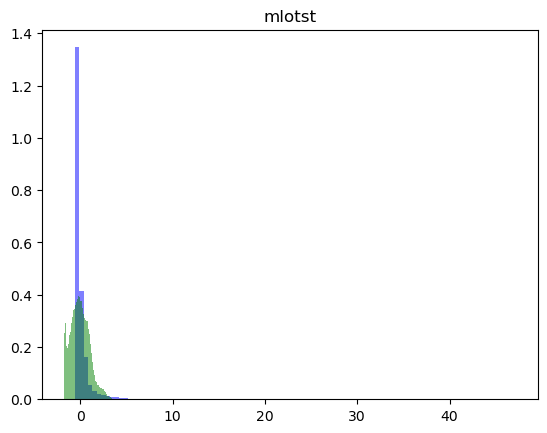

In [20]:
plt.hist(normalize(data_socat["mlotst"]), 100, density=True, facecolor='blue', alpha=0.5);
plt.hist(normalize(np.log(data_socat["mlotst"])), 100, density=True, facecolor='green', alpha=0.5);
plt.title("mlotst")

Text(0.5, 1.0, 'chlos')

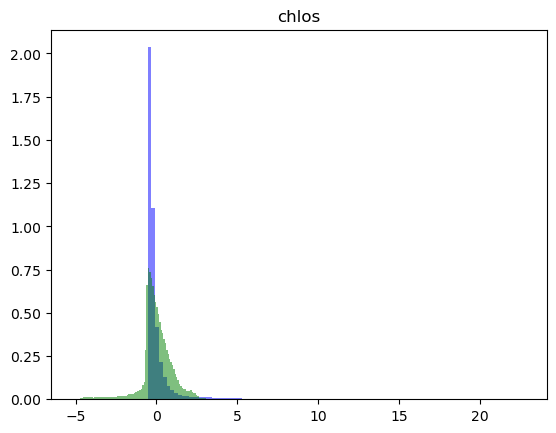

In [21]:
plt.hist(normalize(data_socat["chlos"]), 100, density=True, facecolor='blue', alpha=0.5);
plt.hist(normalize(np.log(data_socat["chlos"])), 100, density=True, facecolor='green', alpha=0.5);
plt.title("chlos")

In [22]:
data_socat["mlotst"] = np.log(data_socat["mlotst"])
data_socat["chlos"] = np.log(data_socat["chlos"])

####  Split into training and validation sets

In [23]:
np.random.seed(0)
random.seed(0)
train_valid_split = 0.833 
# As before, have 5/6 as training and 1/6 as validation data
random_indices = np.arange(len(data_socat["tos"]), dtype=int)

random.shuffle(random_indices)

ntrain_socat = int(len(data_socat["tos"]) * train_valid_split)
train_socat = {key: data_socat[key][random_indices][:ntrain_socat]
               for key in data_socat}
valid_socat = {key: data_socat[key][random_indices][ntrain_socat:]
               for key in data_socat}

#### normalize data and convert into feature and label arrays

In [24]:
feature_keys = ["tos", "sos", "mlotst", "zos", "chlos", "siconc", "uas", "vas",
                "co2", "mon_sin", "mon_cos", "nvector1", "nvector2", "nvector3"]

with open('../../data/cmip6_base_model_1model_train_feature_means.pkl', 'rb') as f:
    train_feature_means = pickle.load(f)

with open('../../data/cmip6_base_model_1model_train_feature_stds.pkl', 'rb') as f:
    train_feature_stds = pickle.load(f)

# Processing the socat data
train_features = np.concatenate([(
    train_socat[key][:, np.newaxis] - train_feature_means[key]
) / train_feature_stds[key] for key in feature_keys], axis=1)

valid_features = np.concatenate([(
    valid_socat[key][:, np.newaxis] - train_feature_means[key]
) / train_feature_stds[key] for key in feature_keys], axis=1)

train_labels = train_socat["fco2"] # maybe add [:, np.newaxis]

valid_labels = valid_socat["fco2"] # maybe add [:, np.newaxis]

In [25]:
# add additional dictionaries train_TS and valid_TS that only contain T and S normalized
# for fCO2 surrogate model
# original feature means and stds used to train the fCO2 surrogate model:
alk_range = [1000e-6, 3000e-6]
dic_range = [1000e-6, 3000e-6]
tem_range = [-2, 35]
sal_range = [10, 50]
sil_range = [0, 134e-6]
phos_range = [0, 4e-6]

sample_means = {"talkos":(alk_range[0] + alk_range[1]) / 2,
                 "dissicos":dic_range[0] + (dic_range[1] - dic_range[0]) / 4,
                 "tos":(tem_range[0] + tem_range[1]) / 2,
                 "sos":(sal_range[0] + sal_range[1]) / 2,
                 "sios":(sil_range[0] + sil_range[1]) / 2,
                 "po4os":(phos_range[0] + phos_range[1]) / 2}

sample_stds = {"talkos":(alk_range[1] - alk_range[0]) / np.sqrt(12),
                 "dissicos":(dic_range[1] - dic_range[0]) * np.sqrt(7 / 144),
                 "tos":(tem_range[1] - tem_range[0]) / np.sqrt(12),
                 "sos":(sal_range[1] - sal_range[0]) / np.sqrt(12),
                 "sios":(sil_range[1] - sil_range[0]) / np.sqrt(12),
                 "po4os":(phos_range[1] - phos_range[0]) / np.sqrt(12)}

train_TS = np.concatenate([
    (train_socat[key][:, np.newaxis] - sample_means[key]) / sample_stds[key]
    for key in ["tos", "sos"]
], axis=1)

valid_TS = np.concatenate([
    (valid_socat[key][:, np.newaxis] - sample_means[key]) / sample_stds[key]
    for key in ["tos", "sos"]
], axis=1)

In [26]:
print(np.mean(train_TS[:, 0]))
print(np.std(train_TS[:, 0]))
print(np.mean(train_TS[:, 1]))
print(np.std(train_TS[:, 1]))

0.03970933
0.8650753
0.35846293
0.2096405


In [27]:
train_TS.shape

(254594, 2)

In [28]:
print("Check shapes of matrices.")
print(train_features.shape)
print(valid_features.shape)
print(train_labels.shape)
print(valid_labels.shape)

Check shapes of matrices.
(254594, 14)
(51042, 14)
(254594,)
(51042,)


In [29]:
print("Check normalization of features.")
print(np.mean(train_features, axis=0))
print(np.std(train_features, axis=0))
print(np.mean(valid_features, axis=0))
print(np.std(valid_features, axis=0))

Check normalization of features.
[ 0.27735484  0.11476019 -0.16534708  0.89513512  0.59769618 -0.43598998
 -0.0445879  -0.03787942  0.31043901 -0.01253773  0.00836693  0.42957695
 -0.1573055   0.12446984]
[0.80589847 1.34643936 0.88365261 0.9053184  0.87588169 0.2699655
 0.94426185 1.01322014 0.908408   0.99394295 1.00589966 0.84564065
 0.94382674 1.10535926]
[ 0.27250657  0.10830369 -0.158685    0.89320825  0.59412615 -0.43569409
 -0.04798977 -0.04522697  0.305734   -0.01518282  0.02897768  0.42424814
 -0.15631779  0.13073439]
[0.80837259 1.35907738 0.88415226 0.91346233 0.87818654 0.26927226
 0.94758077 1.01132041 0.90987586 0.99540188 1.00402322 0.85011556
 0.94197252 1.10302027]


# Define neural network and training procedure

In [30]:
class flexible_MLP(nn.Module):
    def __init__(self, input_size, hidden_size_part1, inner_output_size, hidden_size_part2):
        super().__init__()
        self.device = torch.device("cuda")
        self.linear1 = nn.Linear(input_size, hidden_size_part1, device=self.device)
        self.linear2 = nn.Linear(hidden_size_part1, hidden_size_part1, device=self.device)
        self.linear3 = nn.Linear(hidden_size_part1, hidden_size_part1, device=self.device)
        self.linear4 = nn.Linear(hidden_size_part1, inner_output_size, device=self.device)
        
        self.linear1_socat = nn.Linear(inner_output_size + 2, hidden_size_part2, device=self.device)
        self.linear2_socat = nn.Linear(hidden_size_part2, hidden_size_part2, device=self.device)
        self.linear3_socat = nn.Linear(hidden_size_part2, hidden_size_part2, device=self.device)
        self.linear4_socat = nn.Linear(hidden_size_part2, 1, device=self.device)
    
    def forward(self, x, TS_data=None, mode=None):
        """
        mode can be socat or None
        (for None, only the first part of the network is used)
        TS_data only needs to be provided if mode is socat
        """
        x = x.to(self.device)
        x = F.elu(self.linear1(x))
        x = F.elu(self.linear2(x))
        x = F.elu(self.linear3(x))
        x = self.linear4(x)
        if mode == "socat":
            x_p1 = x[:, :2]
            x_p2 = x[:, 2:]
            x = torch.cat((x_p1, TS_data, x_p2), dim=-1)
            x = F.elu(self.linear1_socat(x))
            x = F.elu(self.linear2_socat(x))
            x = F.elu(self.linear3_socat(x))
            x = F.elu(self.linear4_socat(x))
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = '../../models'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

In [31]:
model = flexible_MLP(14, 160, 4, 160)
print(model)

print("Update the base and socat subnets and freeze these layers")
base_state_dict = torch.load("../../models/single_CMIP6_model_experiments/CMIP6_base_model_1model_160x3_elu_10000epo.pth")
socat_state_dict = torch.load("../../models/fCO2_model_160x3_elu_10000epo.pth")

with torch.no_grad(): # not sure whether interfers with autograd
    model.linear1.weight.copy_(base_state_dict["linear1.weight"])
    model.linear1.bias.copy_(base_state_dict["linear1.bias"])
    model.linear2.weight.copy_(base_state_dict["linear2.weight"])
    model.linear2.bias.copy_(base_state_dict["linear2.bias"])
    model.linear3.weight.copy_(base_state_dict["linear3.weight"])
    model.linear3.bias.copy_(base_state_dict["linear3.bias"])
    model.linear4.weight.copy_(base_state_dict["linear4.weight"])
    model.linear4.bias.copy_(base_state_dict["linear4.bias"])
    
    model.linear1_socat.weight.copy_(socat_state_dict["linear1.weight"])
    model.linear1_socat.bias.copy_(socat_state_dict["linear1.bias"])
    model.linear2_socat.weight.copy_(socat_state_dict["linear2.weight"])
    model.linear2_socat.bias.copy_(socat_state_dict["linear2.bias"])
    model.linear3_socat.weight.copy_(socat_state_dict["linear3.weight"])
    model.linear3_socat.bias.copy_(socat_state_dict["linear3.bias"])
    model.linear4_socat.weight.copy_(socat_state_dict["linear4.weight"])
    model.linear4_socat.bias.copy_(socat_state_dict["linear4.bias"])

model.linear1_socat.weight.requires_grad = False
model.linear1_socat.bias.requires_grad = False
model.linear2_socat.weight.requires_grad = False
model.linear2_socat.bias.requires_grad = False
model.linear3_socat.weight.requires_grad = False
model.linear3_socat.bias.requires_grad = False
model.linear4_socat.weight.requires_grad = False
model.linear4_socat.bias.requires_grad = False

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

flexible_MLP(
  (linear1): Linear(in_features=14, out_features=160, bias=True)
  (linear2): Linear(in_features=160, out_features=160, bias=True)
  (linear3): Linear(in_features=160, out_features=160, bias=True)
  (linear4): Linear(in_features=160, out_features=4, bias=True)
  (linear1_socat): Linear(in_features=6, out_features=160, bias=True)
  (linear2_socat): Linear(in_features=160, out_features=160, bias=True)
  (linear3_socat): Linear(in_features=160, out_features=160, bias=True)
  (linear4_socat): Linear(in_features=160, out_features=1, bias=True)
)
Update the base and socat subnets and freeze these layers
Number of trainable parameters in the model: 54564


In [32]:
def training_dataloader(features, labels, batch_size, TS=None):
    ntrain = len(labels)
    nbatch = ntrain // batch_size
    indices = np.arange(ntrain, dtype=int)
    random.shuffle(indices)
    batch_indices = np.split(indices[:nbatch * batch_size], nbatch)
    if TS is None:
        batch_data = [(torch.from_numpy(np.take(features, ind, axis=0).astype("float32")).to(torch.device("cuda")),
                       torch.from_numpy(np.take(labels, ind, axis=0).astype("float32")).to(torch.device("cuda")))
                      for ind in batch_indices]
    elif TS is not None:
        batch_data = [(torch.from_numpy(np.take(features, ind, axis=0).astype("float32")).to(torch.device("cuda")),
                       torch.from_numpy(np.take(labels, ind, axis=0).astype("float32")).to(torch.device("cuda")),
                       torch.from_numpy(np.take(TS, ind, axis=0).astype("float32")).to(torch.device("cuda")))
                      for ind in batch_indices]
    return batch_data

In [33]:
loss_function = nn.MSELoss()

In [34]:
def train_one_epoch(optimizer):
    running_loss = 0. # running loss over all batches in the epoch

    training_data = training_dataloader(train_features,
                                        train_labels,
                                        batch_size, train_TS)
    
    for batch in training_data:
        features, labels, TS = batch
        optimizer.zero_grad()
        outputs = torch.squeeze(model(features, TS, 'socat'))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.detach().cpu().item()

    ntrain = len(train_labels)
    nbatch = ntrain // batch_size

    return running_loss / nbatch

In [35]:
def calc_gammar(reduction_factor, nepochs):                                                                                                                                                                       
    return reduction_factor**(1 / nepochs)

def train(batch_size, n_epochs, optimizer, scheduler):
    train_stats = {"train_loss":[], "valid_loss":[], "learn_rate":[]}

    pbar = tqdm(range(n_epochs), postfix=f'epoch 0/{n_epochs}')
    
    for epoch in pbar:

        model.train()

        train_loss_epoch = train_one_epoch(optimizer)

        model.eval()
        with torch.no_grad():
            valid_outputs = torch.squeeze(model(
                torch.from_numpy(valid_features.astype("float32")).to(torch.device("cuda")),
                torch.from_numpy(valid_TS.astype("float32")).to(torch.device("cuda")),
                "socat"))
            valid_loss_epoch = loss_function(
                valid_outputs, torch.from_numpy(valid_labels).to(torch.device("cuda"))
                                        ).detach().cpu().item()
                
        train_stats["train_loss"].append(train_loss_epoch)
        train_stats["valid_loss"].append(valid_loss_epoch)
        
        lr = scheduler.get_last_lr()[0]
        train_stats["learn_rate"].append(lr)

        scheduler.step()

        pbar.set_postfix({'epoch': f'{epoch+1}/{n_epochs}',
                          'train_loss': f'{train_loss_epoch:.3e}',
                          'valid_loss': f'{valid_loss_epoch:.3e}',
                          'learn_rate': f'{lr:.3e}'}
                        )

    return train_stats

# Test zero-shot inference with pretrained base model

Mostly to test whether the order of magnitude of the output fits.

**On socat validation data**

In [56]:
def MSE(x, y, axis=0):
    return np.sum((x - y)**2, axis=axis) / len(x)

In [37]:
model.eval()
with torch.no_grad():
    model_output_zero_shot = model(
        torch.from_numpy(valid_features.astype("float32")).to(torch.device("cuda")),
        torch.from_numpy(valid_TS.astype("float32")).to(torch.device("cuda")),
        'socat').detach().cpu().numpy().squeeze()

In [38]:
print("RMSE: ", np.sqrt(MSE(valid_labels, model_output_zero_shot)))
print("Maximum absolute deviation: ", np.max(np.abs(model_output_zero_shot-valid_labels)))
print("99.9th percentile of absolute deviation (1000 val's larger): ",
      np.percentile(np.abs(model_output_zero_shot-valid_labels), q=99.9))
print("99.99th percentile of absolute deviation (100 val's larger): ",
      np.percentile(np.abs(model_output_zero_shot-valid_labels), q=99.99))
print("99.999th percentile of absolute deviation (10 val's larger): ",
      np.percentile(np.abs(model_output_zero_shot-valid_labels), q=99.999))
print("Fraction of variance unexplained: ", MSE(valid_labels, model_output_zero_shot) / np.var(valid_labels))
print(np.var(valid_labels))

RMSE:  52.96460193341132
Maximum absolute deviation:  2033.0059087425434
99.9th percentile of absolute deviation (1000 val's larger):  234.39676746256265
99.99th percentile of absolute deviation (100 val's larger):  1075.6206906954046
99.999th percentile of absolute deviation (10 val's larger):  1688.8722776111322
Fraction of variance unexplained:  1.4955705400420307
1875.7049452751864


In [39]:
print("A sample to get an idea about how bad the prediction is: ")
print(model_output_zero_shot[:10])
print(valid_labels[:10])

A sample to get an idea about how bad the prediction is: 
[354.36935 347.37076 295.14725 294.7557  327.6502  438.1601  315.6382
 368.96817 422.77365 374.0841 ]
[428.03874286 346.25472006 362.58922625 353.47970849 349.4126703
 417.48256    362.8946717  362.75771674 361.40264783 411.70325307]


# Training

#### Freeze all layers of the base model despite the last linear projection layer and train it

In [158]:
model.linear1.weight.requires_grad = False
model.linear1.bias.requires_grad = False
model.linear2.weight.requires_grad = False
model.linear2.bias.requires_grad = False
model.linear3.weight.requires_grad = False
model.linear3.bias.requires_grad = False

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

Number of trainable parameters in the model: 644


In [159]:
batch_size = 1000
n_epochs = 2_000

base_learning_rate = 1e-3
gamma = calc_gammar(0.1, 2000)

#optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                             gamma=gamma)

train_stats = train(batch_size, n_epochs, optimizer, scheduler)

100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:42<00:00,  3.43it/s, epoch=2000/2000, train_loss=3.042e+02, valid_loss=2.975e+02, learn_rate=1.001e-04]


#### Also unfreeze the second-last layer and retrain also that on a small learning rate

In [160]:
model.linear3.weight.requires_grad = True
model.linear3.bias.requires_grad = True

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

Number of trainable parameters in the model: 26404


In [161]:
batch_size = 1000
n_epochs = 4_000

base_learning_rate = 1e-4
gamma = calc_gammar(0.1, 4000) # 1 for no learning rate decay

#optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                             gamma=gamma)

train_stats = train(batch_size, n_epochs, optimizer, scheduler)

100%|██████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [20:55<00:00,  3.19it/s, epoch=4000/4000, train_loss=2.708e+01, valid_loss=3.825e+01, learn_rate=1.001e-05]


#### Unfreeze the remaining model and retrain with an even smaller learning rate

In [162]:
model.linear1.weight.requires_grad = True
model.linear1.bias.requires_grad = True
model.linear2.weight.requires_grad = True
model.linear2.bias.requires_grad = True

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

Number of trainable parameters in the model: 54564


In [163]:
batch_size = 1000
n_epochs = 4_000

base_learning_rate = 1e-5
gamma = 1 # for no learning rate decay

#optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                             gamma=gamma)

train_stats = train(batch_size, n_epochs, optimizer, scheduler)

100%|██████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [22:48<00:00,  2.92it/s, epoch=4000/4000, train_loss=2.028e+01, valid_loss=3.242e+01, learn_rate=1.000e-05]


In [164]:
model.save("CMIP6_base_model_1model_tuned_on_MPI-ESM.pth")

#### Other option: fully retrain the base network (no transfer learning case)

In [56]:
model = flexible_MLP(14, 160, 4, 160)
print(model)

with torch.no_grad(): # not sure whether interfers with autograd
    model.linear1_socat.weight.copy_(socat_state_dict["linear1.weight"])
    model.linear1_socat.bias.copy_(socat_state_dict["linear1.bias"])
    model.linear2_socat.weight.copy_(socat_state_dict["linear2.weight"])
    model.linear2_socat.bias.copy_(socat_state_dict["linear2.bias"])
    model.linear3_socat.weight.copy_(socat_state_dict["linear3.weight"])
    model.linear3_socat.bias.copy_(socat_state_dict["linear3.bias"])
    model.linear4_socat.weight.copy_(socat_state_dict["linear4.weight"])
    model.linear4_socat.bias.copy_(socat_state_dict["linear4.bias"])

model.linear1_socat.weight.requires_grad = False
model.linear1_socat.bias.requires_grad = False
model.linear2_socat.weight.requires_grad = False
model.linear2_socat.bias.requires_grad = False
model.linear3_socat.weight.requires_grad = False
model.linear3_socat.bias.requires_grad = False
model.linear4_socat.weight.requires_grad = False
model.linear4_socat.bias.requires_grad = False

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

flexible_MLP(
  (linear1): Linear(in_features=14, out_features=160, bias=True)
  (linear2): Linear(in_features=160, out_features=160, bias=True)
  (linear3): Linear(in_features=160, out_features=160, bias=True)
  (linear4): Linear(in_features=160, out_features=4, bias=True)
  (linear1_socat): Linear(in_features=6, out_features=160, bias=True)
  (linear2_socat): Linear(in_features=160, out_features=160, bias=True)
  (linear3_socat): Linear(in_features=160, out_features=160, bias=True)
  (linear4_socat): Linear(in_features=160, out_features=1, bias=True)
)
Number of trainable parameters in the model: 54564


In [57]:
batch_size = 1000
n_epochs = 10_000

base_learning_rate = 1e-3
gamma = calc_gammar(0.1, 5000)

#optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                                 gamma=gamma)

train_stats_full_retrain = train(batch_size, n_epochs, optimizer, scheduler)

100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [59:38<00:00,  2.79it/s, epoch=10000/10000, train_loss=1.153e+01, valid_loss=2.683e+01, learn_rate=1.000e-05]


In [58]:
model.save("training_MPI-ESM_on_fCO2_at_SOCAT_locations.pth")

# Test model performance for fCO2, talkos, dissicos, sios, po4os

In [40]:
# Reload the finetuned model from above
model_scratch = flexible_MLP(14, 160, 4, 160)
model_state_dict = torch.load("../../models/single_CMIP6_model_experiments/training_MPI-ESM_on_fCO2_at_SOCAT_locations.pth")
model_scratch.load_state_dict(model_state_dict)

model_finetuned = flexible_MLP(14, 160, 4, 160)
model_state_dict = torch.load("../../models/single_CMIP6_model_experiments/CMIP6_base_model_1model_tuned_on_MPI-ESM.pth")
model_finetuned.load_state_dict(model_state_dict)

<All keys matched successfully>

#### Performance for fCO2

In [41]:
model_scratch.eval()
with torch.no_grad():
    model_output_scratch = model_scratch(
        torch.from_numpy(valid_features.astype("float32")).to(torch.device("cuda")),
        torch.from_numpy(valid_TS.astype("float32")).to(torch.device("cuda")),
        'socat').detach().cpu().numpy().squeeze()
print("fCO2 RMSE (model trained from scratch): ", np.sqrt(MSE(valid_labels, model_output_scratch)))

model_finetuned.eval()
with torch.no_grad():
    model_output_finetuned = model_finetuned(
        torch.from_numpy(valid_features.astype("float32")).to(torch.device("cuda")),
        torch.from_numpy(valid_TS.astype("float32")).to(torch.device("cuda")),
        'socat').detach().cpu().numpy().squeeze()
print("fCO2 RMSE (finetuned): ", np.sqrt(MSE(valid_labels, model_output_finetuned)))

fCO2 RMSE (model trained from scratch):  5.1796060819514205
fCO2 RMSE (finetuned):  5.693782395568373


#### Performance for talkos, dissicos, sios, po4os

In [42]:
model_scratch.eval()
with torch.no_grad():
    model_output_base_scratch = model_scratch(
        torch.from_numpy(valid_features.astype("float32")).to(torch.device("cuda")),
        torch.from_numpy(valid_TS.astype("float32")).to(torch.device("cuda"))
    ).detach().cpu().numpy().squeeze() # columns: talkos, dissicos, sios. po4os

model_finetuned.eval()
with torch.no_grad():
    model_output_base_finetuned = model_finetuned(
        torch.from_numpy(valid_features.astype("float32")).to(torch.device("cuda")),
        torch.from_numpy(valid_TS.astype("float32")).to(torch.device("cuda"))
    ).detach().cpu().numpy().squeeze() # columns: talkos, dissicos, sios. po4os

In [43]:
sample_means_array = np.concatenate(
    [np.array(sample_means[key])[np.newaxis]
     for key in ['talkos', 'dissicos', 'sios', 'po4os']], axis=0)
sample_stds_array = np.concatenate(
    [np.array(sample_stds[key])[np.newaxis]
     for key in ['talkos', 'dissicos', 'sios', 'po4os']], axis=0)

def denormalize(array):
        return array * sample_stds_array + sample_means_array

# transform units from mol m-3 to mol kg-1 by dividing by density
valid_socat["rho"] = mrhoinsitu(valid_socat["sos"], valid_socat["tos"],
                                5 * np.ones(valid_socat["sos"].shape))
for key in ["talkos", "dissicos", "sios", "po4os"]:
    valid_socat[key + "_mumolkg"] = valid_socat[key] / valid_socat["rho"]

In [44]:
print("Model trained from scratch")
model_output_base_denormalized = denormalize(model_output_base_scratch)
print("talkos RMSE (model trained from scratch): {:.2f}".format(
    np.sqrt(MSE(valid_socat["talkos_mumolkg"], model_output_base_denormalized[:, 0])) * 1e6))
print("dissicos RMSE (model trained from scratch): {:.2f}".format(
    np.sqrt(MSE(valid_socat["dissicos_mumolkg"], model_output_base_denormalized[:, 1])) * 1e6))
print("sios RMSE (model trained from scratch): {:.2f}".format(
    np.sqrt(MSE(valid_socat["sios_mumolkg"], model_output_base_denormalized[:, 2])) * 1e6))
print("po4os RMSE (model trained from scratch): {:.4f}".format(
    np.sqrt(MSE(valid_socat["po4os_mumolkg"], model_output_base_denormalized[:, 3])) * 1e6))
print("==========================")
print("Finetuned model")
model_output_base_denormalized = denormalize(model_output_base_finetuned)
print("talkos RMSE (model trained from scratch): {:.2f}".format(
    np.sqrt(MSE(valid_socat["talkos_mumolkg"], model_output_base_denormalized[:, 0])) * 1e6))
print("dissicos RMSE (model trained from scratch): {:.2f}".format(
    np.sqrt(MSE(valid_socat["dissicos_mumolkg"], model_output_base_denormalized[:, 1])) * 1e6))
print("sios RMSE (model trained from scratch): {:.2f}".format(
    np.sqrt(MSE(valid_socat["sios_mumolkg"], model_output_base_denormalized[:, 2])) * 1e6))
print("po4os RMSE (model trained from scratch): {:.4f}".format(
    np.sqrt(MSE(valid_socat["po4os_mumolkg"], model_output_base_denormalized[:, 3])) * 1e6))

Model trained from scratch
talkos RMSE (model trained from scratch): 2237.17
dissicos RMSE (model trained from scratch): 1729.81
sios RMSE (model trained from scratch): 1781.39
po4os RMSE (model trained from scratch): 8.5220
Finetuned model
talkos RMSE (model trained from scratch): 2156.56
dissicos RMSE (model trained from scratch): 1662.22
sios RMSE (model trained from scratch): 2205.03
po4os RMSE (model trained from scratch): 61.4151


In [45]:
model_no_training = flexible_MLP(14, 160, 4, 160)

with torch.no_grad(): # not sure whether interfers with autograd
    model_no_training.linear1.weight.copy_(base_state_dict["linear1.weight"])
    model_no_training.linear1.bias.copy_(base_state_dict["linear1.bias"])
    model_no_training.linear2.weight.copy_(base_state_dict["linear2.weight"])
    model_no_training.linear2.bias.copy_(base_state_dict["linear2.bias"])
    model_no_training.linear3.weight.copy_(base_state_dict["linear3.weight"])
    model_no_training.linear3.bias.copy_(base_state_dict["linear3.bias"])
    model_no_training.linear4.weight.copy_(base_state_dict["linear4.weight"])
    model_no_training.linear4.bias.copy_(base_state_dict["linear4.bias"])

    model_no_training.linear1_socat.weight.copy_(socat_state_dict["linear1.weight"])
    model_no_training.linear1_socat.bias.copy_(socat_state_dict["linear1.bias"])
    model_no_training.linear2_socat.weight.copy_(socat_state_dict["linear2.weight"])
    model_no_training.linear2_socat.bias.copy_(socat_state_dict["linear2.bias"])
    model_no_training.linear3_socat.weight.copy_(socat_state_dict["linear3.weight"])
    model_no_training.linear3_socat.bias.copy_(socat_state_dict["linear3.bias"])
    model_no_training.linear4_socat.weight.copy_(socat_state_dict["linear4.weight"])
    model_no_training.linear4_socat.bias.copy_(socat_state_dict["linear4.bias"])



model_no_training.eval()
with torch.no_grad():
    model_output_base_no_training = model_no_training(
        torch.from_numpy(valid_features.astype("float32")).to(torch.device("cuda")),
        torch.from_numpy(valid_TS.astype("float32")).to(torch.device("cuda"))
    ).detach().cpu().numpy().squeeze() # columns: talkos, dissicos, sios. po4os

model_output_base_denormalized = denormalize(model_output_base_no_training)
print("talkos RMSE (model trained from scratch): {:.2f}".format(
    np.sqrt(MSE(valid_socat["talkos_mumolkg"], model_output_base_denormalized[:, 0])) * 1e6))
print("dissicos RMSE (model trained from scratch): {:.2f}".format(
    np.sqrt(MSE(valid_socat["dissicos_mumolkg"], model_output_base_denormalized[:, 1])) * 1e6))
print("sios RMSE (model trained from scratch): {:.2f}".format(
    np.sqrt(MSE(valid_socat["sios_mumolkg"], model_output_base_denormalized[:, 2])) * 1e6))
print("po4os RMSE (model trained from scratch): {:.4f}".format(
    np.sqrt(MSE(valid_socat["po4os_mumolkg"], model_output_base_denormalized[:, 3])) * 1e6))

print("Much worse representation of talkos, dissicos, sios, and po4os after training!")

talkos RMSE (model trained from scratch): 71.27
dissicos RMSE (model trained from scratch): 59.78
sios RMSE (model trained from scratch): 11.20
po4os RMSE (model trained from scratch): 0.2870
Much worse representation of talkos, dissicos, sios, and po4os after training!


#### For the fine-tuned model, show how talkos, etc are predicted relative to actual values

In [46]:
print("Load fCO2 surrogate model")

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super().__init__()
        self.device = torch.device("cuda")
        self.linear1 = nn.Linear(input_size, hidden_size_1, device=self.device)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2, device=self.device)
        self.linear3 = nn.Linear(hidden_size_2, hidden_size_3, device=self.device)
        self.linear4 = nn.Linear(hidden_size_3, output_size, device=self.device)

    def forward(self, x):
        x = x.to(self.device)
        x = F.elu(self.linear1(x))
        x = F.elu(self.linear2(x))
        x = F.elu(self.linear3(x))
        x = F.elu(self.linear4(x))
        return x

model_fco2 = MLP(6, 160, 160, 160, 1)
model_state_dict = torch.load("../../models/fCO2_model_160x3_elu_10000epo.pth")
model_fco2.load_state_dict(model_state_dict)

Load fCO2 surrogate model


<All keys matched successfully>

In [47]:
valid_ACSP = np.concatenate([
    ((valid_socat[key] / valid_socat["rho"])[:, np.newaxis]
     - sample_means[key]) / sample_stds[key]
    for key in ["talkos", "dissicos", "sios", "po4os"]
], axis=1)

valid_ACTSSP = np.concatenate([valid_ACSP[:, :2], valid_TS, valid_ACSP[:, -2:]], axis=1)
print(valid_ACTSSP.shape)

(51042, 6)


In [48]:
print("Actual fCO2 (a single cell):")
print(valid_socat["fco2"][0])
print("fCO2 calculated from the true drivers data")
print(calc_fCO2(valid_socat["talkos_mumolkg"],
          valid_socat["dissicos_mumolkg"],
          valid_socat["tos"],
          valid_socat["sos"],
          valid_socat["sios_mumolkg"],
          valid_socat["po4os_mumolkg"])[0])

model_fco2.eval()
with torch.no_grad():
    out = model_fco2(
        torch.from_numpy(valid_ACTSSP.astype("float32")).to(torch.device("cuda"))
    ).detach().cpu().numpy().squeeze()
print(out[0])
print("fCO2 calculated from the drivers predicted by the finetuned network:")
model_output_base_denormalized = denormalize(model_output_base_finetuned)
finetuned_ACTSSP = np.concatenate(
    [model_output_base_denormalized[:, :2], valid_socat["tos"][:, np.newaxis],
     valid_socat["sos"][:, np.newaxis], model_output_base_denormalized[:, -2:]], axis=1)
print("talkos and dissicos given by {:.2f} and {:.2f} mumol kg-1.".format(
    *list(finetuned_ACTSSP[0, :2] * 1e6)))
print(calc_fCO2(*list(finetuned_ACTSSP[0, :]))[0])

finetuned_ACTSSP_norm = np.concatenate(
    [model_output_base_finetuned[:, :2], valid_TS, model_output_base_finetuned[:, -2:]], axis=1)
model_fco2.eval()
with torch.no_grad():
    out = model_fco2(
        torch.from_numpy(finetuned_ACTSSP_norm.astype("float32")).to(torch.device("cuda"))
    ).detach().cpu().numpy().squeeze()
print(out[0])
print("==> The surrogate fCO2 model is doing a good job also outside its training range")

Actual fCO2 (a single cell):
428.03874285756245
fCO2 calculated from the true drivers data
421.23165320066016
421.18143
fCO2 calculated from the drivers predicted by the finetuned network:
talkos and dissicos given by 4761.66 and 3824.96 mumol kg-1.
427.0067283615978
437.95703
==> The surrogate fCO2 model is doing a good job also outside its training range


# Analyse finetuned and from_scratch models across the globe
(not just in the training and validation data)

In [49]:
global_TS = np.concatenate([
    ((cmip6_data[key] - sample_means[key]) / sample_stds[key]).flatten(order='C')[:, np.newaxis]
    for key in ["tos", "sos"]
], axis=1)

In [66]:
global_data = copy.deepcopy(cmip6_data)
global_data["mon_sin"] = np.sin(global_data["mon"] / 12 * 2 * np.pi)
global_data["mon_cos"] = np.cos(global_data["mon"] / 12 * 2 * np.pi)

global_data["nvector1"] = np.sin(global_data["lat"] / 360 * 2 * np.pi)
global_data["nvector2"] = np.sin(global_data["lon"] / 360 * 2 * np.pi)\
    * np.cos(global_data["lat"] / 360 * 2 * np.pi)
global_data["nvector3"] = - np.cos(global_data["lon"] / 360 * 2 * np.pi)\
    * np.cos(global_data["lat"] / 360 * 2 * np.pi)

global_data["mlotst"] = np.log(global_data["mlotst"])
global_data["chlos"] = np.log(global_data["chlos"])

global_data["spco2"] *=  (1e6 / 101325) # transform from bar to muatm
global_data["fco2"] = calc_fCO2_from_pCO2(pco2=global_data["spco2"],
                                                tem=global_data["tos"])

# Processing the socat data
global_features = np.concatenate([((
    global_data[key] - train_feature_means[key]
) / train_feature_stds[key]).flatten(order='C')[:, np.newaxis] for key in feature_keys], axis=1)

In [51]:
print(global_TS.shape)
print(global_features.shape)

(23328000, 2)
(23328000, 14)


In [52]:
def predict_fCO2_globally(model, features, TS_array, nchunks=10):
    """
    apply the neural network to the data in chunks
    - needed to not exceed GPU memory.
    """
    features_split = np.split(features, nchunks, axis=0)
    TS_array_split = np.split(TS_array, nchunks, axis=0)
    model_out_split = []
    for i in range(len(features_split)):
        model.eval()
        with torch.no_grad():
            model_out_split.append(
                model(
                    torch.from_numpy(features_split[i].astype("float32")).to(torch.device("cuda")),
                    torch.from_numpy(TS_array_split[i].astype("float32")).to(torch.device("cuda")),
                    'socat').detach().cpu().numpy().squeeze()
                )

    model_out = np.concatenate(model_out_split, axis=0)
    return model_out


In [53]:
global_finetuned = predict_fCO2_globally(model_finetuned, global_features, global_TS)

In [83]:
global_from_scratch = predict_fCO2_globally(model_scratch, global_features, global_TS)

In [92]:
global_finetuned_reshaped = np.reshape(global_finetuned, newshape=(360, 180, 360), order='C')
global_finetuned_rmse = np.sqrt(MSE(global_finetuned_reshaped, global_data["fco2"]))
global_finetuned_rmse_zonal_mean = np.nanmean(global_finetuned_rmse, axis=1) 

global_from_scratch_reshaped = np.reshape(global_from_scratch, newshape=(360, 180, 360), order='C')
global_from_scratch_rmse = np.sqrt(MSE(global_from_scratch_reshaped, global_data["fco2"]))
global_from_scratch_rmse_zonal_mean = np.nanmean(global_from_scratch_rmse, axis=1)

fco2_std_zonal_mean = np.nanmean(np.std(global_data["fco2"], axis=0), axis=1)

/tmp/ipykernel_7536/1750034802.py:3: RuntimeWarning: Mean of empty slice
  global_finetuned_rmse_zonal_mean = np.nanmean(global_finetuned_rmse, axis=1)
/tmp/ipykernel_7536/1750034802.py:7: RuntimeWarning: Mean of empty slice
  global_from_scratch_rmse_zonal_mean = np.nanmean(global_from_scratch_rmse, axis=1)
/tmp/ipykernel_7536/1750034802.py:9: RuntimeWarning: Mean of empty slice
  fco2_std_zonal_mean = np.nanmean(np.std(global_data["fco2"], axis=0), axis=1)


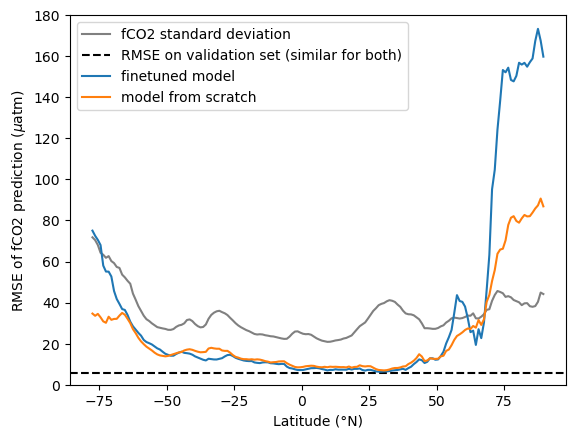

In [99]:
plt.plot(np.arange(-89.5, 90), fco2_std_zonal_mean, label="fCO2 standard deviation",
        color="grey")
plt.axhline(y=5.7, color="k", linestyle="--", label="RMSE on validation set (similar for both)")
plt.plot(np.arange(-89.5, 90), global_finetuned_rmse_zonal_mean, label="finetuned model")
plt.plot(np.arange(-89.5, 90), global_from_scratch_rmse_zonal_mean, label="model from scratch")
plt.xlabel("Latitude (°N)")
plt.ylabel("RMSE of fCO2 prediction ($\mu$atm)")
plt.ylim([0, 180])
plt.legend()
plt.savefig("../../report/source_files/figures/MPI-ESM_global_model_rmse.pdf")